In [89]:
from abc import ABC, abstractmethod
from collections.abc import Generator
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torchvision.datasets
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanMetric
from torchsummary import summary
from torchvision import transforms


### Загрузите обучающий и тестовый датасеты

In [81]:
class FashionMNISTDataModule(pl.LightningDataModule):
    """Dataset of Zalando's article images."""

    def __init__(self, batch_size: int = 64, data_dir: Path | None = None, transform=None) -> None:
        """Init datamodule."""
        super().__init__()
        if data_dir is None:
            data_dir = Path("./datasets/autoencoders")
        self.data_dir = data_dir
        self.batch_size = batch_size
        if transform is None:
            transform = torchvision.transforms.ToTensor()
        self.transform = transform

    def setup(self, stage: str | None = None) -> None:
        """Настроить датасет."""
        dataset = torchvision.datasets.FashionMNIST(
            root=self.data_dir,
            train=True,
            download=True,
            transform=self.transform,
        )
        self.num_classes = len(dataset.classes)
        self.train_ds, self.val_ds = random_split(dataset, [55000, 5000])
        self.test_ds = torchvision.datasets.FashionMNIST(
            self.data_dir,
            train=False,
            download=True,
            transform=self.transform,
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=7,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=7, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size)


In [82]:
data = FashionMNISTDataModule()

### Выведите на экран несколько изображений обучающего датасета

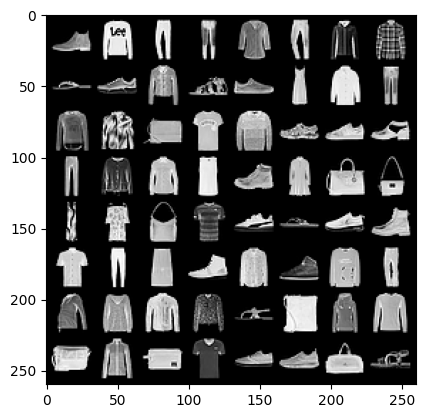

Количество классов: 10


In [83]:
torch.manual_seed(42)

data.setup()

imgs, labels = next(iter(data.test_dataloader()))
grid = torchvision.utils.make_grid(imgs, padding=4)
plt.imshow(grid.permute(1, 2, 0))
plt.show()
print(f"Количество классов: {data.num_classes}")

### Обучите модель VGG и ResNet модели для классификации изображений. Попробуйте разные оптимизаторы: SGD, Adam.

#### Вспомогательные утилиты для вывода графиков и обучения

In [335]:
class BaseModel(pl.LightningModule, ABC):
    """База для обучения модели."""

    def __init__(self):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss()
        self.model = self._get_model()

    @abstractmethod
    def _get_model(self) -> nn.Module:
        pass

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def _step(self, batch: torch.Tensor, batch_idx: int, name: str):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log(f"{name}_loss", loss)
        self.log(f"{name}_acc", acc, prog_bar=True)
        return loss

    def training_step(self, batch: torch.Tensor, batch_idx: int):
        return self._step(batch, batch_idx, "train")

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        self._step(batch, batch_idx, "val")

    def test_step(self, batch: torch.Tensor, batch_idx: int):
        self._step(batch, batch_idx, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [306]:
def plot_metrics(metrics_paths: Generator[Path, None, None]) -> None:
    """Отобразить метрики сохраненные CSVLogger."""
    metrics = None
    last_epoch = 0
    for path in metrics_paths:
        print(path)
        data = pd.read_csv(path)
        data_max_epoch = data["epoch"].max()
        data["epoch"] = data["epoch"] + last_epoch
        metrics = data if metrics is None else pd.concat([metrics, data])
        last_epoch += data_max_epoch + 1
    metrics = (
        metrics.fillna(0)
        .groupby("epoch")
        .agg(
            {
                "train_acc": "mean",
                "train_loss": "mean",
                "val_acc": "sum",
                "val_loss": "sum",
            },
        )
        .reset_index()
    )
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.lineplot(metrics, x="epoch", y="train_loss", ax=axes[0], label="train_loss")
    sns.lineplot(metrics, x="epoch", y="val_loss", ax=axes[0], label="val_loss")
    sns.lineplot(metrics, x="epoch", y="train_acc", ax=axes[1], label="train_acc")
    sns.lineplot(metrics, x="epoch", y="val_acc", ax=axes[1], label="val_acc")
    axes[0].set_ylabel("")
    axes[0].legend()
    axes[1].set_ylabel("")
    axes[1].legend()
    plt.show()

In [307]:
def run_learning(
    logs_name: str,
    model: BaseModel,
    dataset: FashionMNISTDataModule,
    max_epochs: int = 10,
) -> tuple[Generator[Path, None, None], BaseModel]:
    """Настроить тренировку модели, а если есть чекпоинт восстановить последнее состояние и начать обучение."""
    logger = CSVLogger("logs", name=logs_name)
    checkpoints_dir = Path(f"checkpoints/{logs_name}")
    checkpoint_callback = ModelCheckpoint(
        monitor="val_acc",
        dirpath=checkpoints_dir,
        filename="mnist-{epoch:02d}-{val_acc:.4f}",
        save_top_k=3,
        mode="max",
        save_last=True,
    )

    ckpts = list(Path(checkpoints_dir).glob("last-*.ckpt"))
    if len(ckpts) > 0:
        ckpts.sort(key=lambda x: x.stat().st_mtime, reverse=True)
        model = model.__class__.load_from_checkpoint(ckpts[0])

    if max_epochs > 0:
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            logger=logger,
            callbacks=[checkpoint_callback],
            accelerator="auto",
        )
        trainer.fit(model, datamodule=dataset)

    return Path(f"logs/{logs_name}").glob("*/metrics.csv"), model

#### Определение модели VGG11

In [308]:
torch.manual_seed(42)


class Vgg11Model(BaseModel):
    def __init__(self):
        super().__init__()

    def _get_model(self) -> nn.Module:
        vgg11 = torchvision.models.vgg11(weights=None)
        vgg11.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        vgg11.classifier[-1] = nn.Linear(in_features=4096, out_features=10, bias=True)
        return vgg11

Для vgg11 размер входных изображений 28x28 слишком мал, необходимо увеличить каждое изображения хотя бы в 2 раза.

In [309]:
torch.manual_seed(42)

vgg_dataset = FashionMNISTDataModule(
    transform=transforms.Compose([transforms.Resize((28 * 2, 28 * 2)), transforms.ToTensor()]),
)

Можно вывести получившуюся модель, изучить слои и количество параметров

In [310]:
torch.manual_seed(42)

vgg_dataset.setup()
imgs, labels = next(iter(vgg_dataset.test_dataloader()))
vgg11 = Vgg11Model()
summary(vgg11, imgs.shape[1:], device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]             640
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]          73,856
              ReLU-5          [-1, 128, 28, 28]               0
         MaxPool2d-6          [-1, 128, 14, 14]               0
            Conv2d-7          [-1, 256, 14, 14]         295,168
              ReLU-8          [-1, 256, 14, 14]               0
            Conv2d-9          [-1, 256, 14, 14]         590,080
             ReLU-10          [-1, 256, 14, 14]               0
        MaxPool2d-11            [-1, 256, 7, 7]               0
           Conv2d-12            [-1, 512, 7, 7]       1,180,160
             ReLU-13            [-1, 512, 7, 7]               0
           Conv2d-14            [-1, 51

#### Обучение VGG11

In [311]:
torch.manual_seed(42)
vgg11 = Vgg11Model()
metrics_paths, vgg11 = run_learning("zolandos_fashion_mnist", vgg11, vgg_dataset, max_epochs=0)

Вывод графиков обучения модели

logs\zolandos_fashion_mnist\version_0\metrics.csv
logs\zolandos_fashion_mnist\version_1\metrics.csv
logs\zolandos_fashion_mnist\version_3\metrics.csv


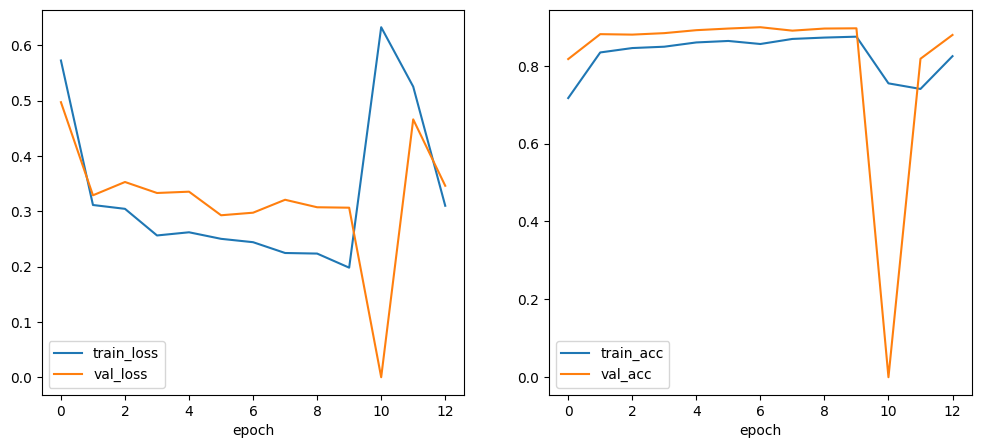

In [312]:
plot_metrics(metrics_paths)

Исходя из графиков выше у модели еще есть потенциал к дальнейшему обучению, можно загрузить из checkpoint-а и продолжить обучение. Максимальная полученная точность составляет 91% т. е модель правильно угадывает в 91% случаев.

#### Обучение VGG11 с оптимизатором SGD

In [313]:
torch.manual_seed(42)


class Vgg11ModelSGD(Vgg11Model):
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), momentum=0.9)

In [314]:
torch.manual_seed(42)
vgg11_sgd = Vgg11ModelSGD()
metrics_paths, vgg11_sgd = run_learning("zolandos_fashion_mnist_sgd", vgg11_sgd, vgg_dataset, max_epochs=0)

logs\zolandos_fashion_mnist_sgd\version_0\metrics.csv
logs\zolandos_fashion_mnist_sgd\version_1\metrics.csv


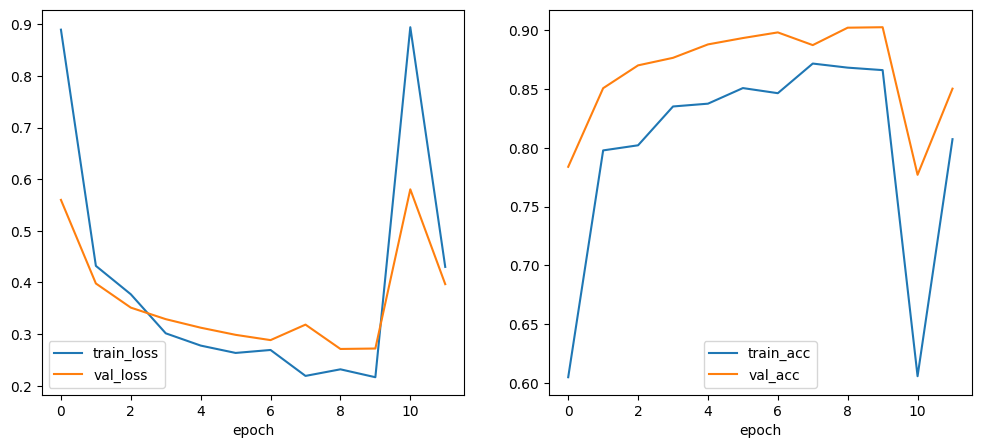

In [315]:
plot_metrics(metrics_paths)

#### Определение модели ResNet

In [316]:
torch.manual_seed(42)


class ResNetModel(BaseModel):
    def _get_model(self) -> nn.Module:
        resnet = torchvision.models.resnet18(weights=None)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        resnet.fc = nn.Linear(in_features=512, out_features=10, bias=True)
        return resnet

Вывод получившейся структуры

In [317]:
resnet = ResNetModel()
data.setup()
imgs, labels = next(iter(data.test_dataloader()))
summary(resnet, imgs.shape[1:], device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,864
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
       BasicBlock-11           [-1, 64, 14, 14]               0
           Conv2d-12           [-1, 64, 14, 14]          36,864
      BatchNorm2d-13           [-1, 64, 14, 14]             128
             ReLU-14           [-1, 64,

#### Обучение модели ResNet

In [318]:
torch.manual_seed(42)
resnet = ResNetModel()
metrics_paths, resnet = run_learning("zolandos_fashion_mnist_resnet", resnet, data, max_epochs=0)

logs\zolandos_fashion_mnist_resnet\version_0\metrics.csv


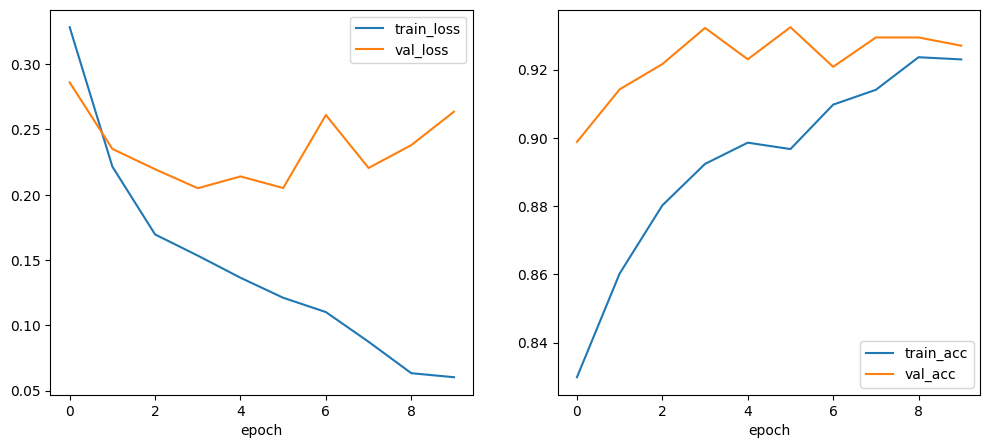

In [319]:
plot_metrics(metrics_paths)

#### Обучение ResNet с оптимизатором SGD

In [320]:
torch.manual_seed(42)


class ResNetModelSGD(ResNetModel):
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), momentum=0.9)

In [321]:
torch.manual_seed(42)
resnet_sgd = ResNetModelSGD()
metrics_paths, resnet_sgd = run_learning("zolandos_fashion_mnist_resnet_sgd", resnet_sgd, data, max_epochs=0)

logs\zolandos_fashion_mnist_resnet_sgd\version_0\metrics.csv


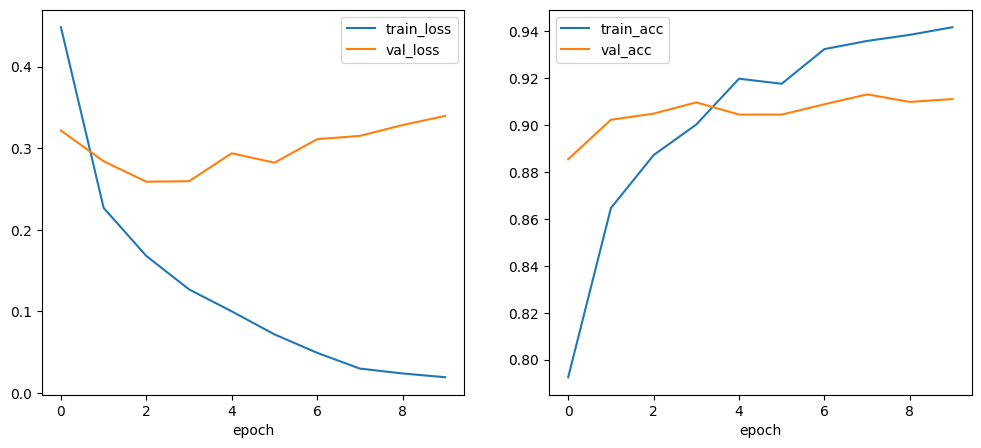

In [322]:
plot_metrics(metrics_paths)

### Выведите метрики качества обученных моделей для тестовой выборки

#### Тестирование vgg11 + Adam

In [323]:
trainer = pl.Trainer(logger=False)
trainer.test(vgg11, vgg_dataset)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\dilst\Documents\uni_lessons_da_and_ml\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8797000050544739
        test_loss           0.35000962018966675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.35000962018966675, 'test_acc': 0.8797000050544739}]

На тестовых данных, после обучения удается распозновать верно в 87%

#### Тестирование VGG11 + SGD

In [324]:
trainer = pl.Trainer(logger=False)
trainer.test(vgg11_sgd, vgg_dataset)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8478999733924866
        test_loss           0.4166333079338074
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4166333079338074, 'test_acc': 0.8478999733924866}]

На тестовых данных, после обучения удается распозновать верно в 84%

#### ResNet + Adam

In [325]:
trainer = pl.Trainer(logger=False)
trainer.test(resnet, data)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.10000000149011612
        test_loss           2.2904372215270996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.2904372215270996, 'test_acc': 0.10000000149011612}]

#### ResNet + SGD

In [326]:
trainer = pl.Trainer(logger=False)
trainer.test(resnet_sgd, data)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.10000000149011612
        test_loss           2.2904372215270996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.2904372215270996, 'test_acc': 0.10000000149011612}]

### Постройте и обучите модель автокодировщика

In [ ]:
class ConvAutoEncoder(pl.LightningModule):
    """Сверточный автокодировщик.

    Архитектура:
    1x28x28 -> Conv(32, k3, s2, p1) -> 32x14x14
            -> Conv(64, k3, s2, p1) -> 64x7x7
            -> Flatten -> Linear(64*7*7 -> latent_dim)

    Декодер:
    latent_dim -> Linear(latent_dim -> 64*7*7) -> Unflatten
               -> ConvT(64->32, k3, s2, p1, out_pad=1) -> 32x14x14
               -> ConvT(32->1,  k3, s2, p1, out_pad=1) -> 1x28x28
               -> Sigmoid (чтобы вернуть [0,1] как у входа)
    """

    def __init__(self, latent_dim: int = 64, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> 32x14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> 64x7x7
            nn.ReLU(inplace=True),
        )
        self.enc_lin = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.dec_lin = nn.Linear(latent_dim, 64 * 7 * 7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> 32x14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> 1x28x28
            nn.Sigmoid(),  # возвращаем в [0,1] под MSE
        )

        # метрики (средние за эпоху)
        self.train_loss_metric = MeanMetric()
        self.val_loss_metric = MeanMetric()
        self.test_loss_metric = MeanMetric()

    def encode(self, x):
        x = self.enc(x)
        x = torch.flatten(x, 1)
        z = self.enc_lin(x)
        return z

    def decode(self, z):
        x = self.dec_lin(z)
        x = x.view(x.size(0), 64, 7, 7)
        x = self.dec(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat

    def _shared_step(self, batch, stage: str):
        x, _ = batch  # метки не нужны
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        # логгируем по батчам
        self.log(f"{stage}_loss_step", loss, prog_bar=True, on_step=True, on_epoch=False)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._shared_step(batch, "train")
        self.train_loss_metric.update(loss.detach())
        return loss

    def on_train_epoch_end(self):
        self.log("train_loss", self.train_loss_metric.compute(), prog_bar=True)
        self.train_loss_metric.reset()

    def validation_step(self, batch, batch_idx):
        loss = self._shared_step(batch, "val")
        self.val_loss_metric.update(loss.detach())

    def on_validation_epoch_end(self):
        self.log("val_loss", self.val_loss_metric.compute(), prog_bar=True)
        self.val_loss_metric.reset()

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.test_loss_metric.update(loss.detach())

    def on_test_epoch_end(self):
        self.log("test_loss", self.test_loss_metric.compute())
        self.test_loss_metric.reset()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [92]:
autoenc = ConvAutoEncoder()
trainer = pl.Trainer(max_epochs=30)
trainer.fit(autoenc, data)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name              | Type       | Params | Mode 
---------------------------------------------------------
0 | enc               | Sequential | 18.8 K | train
1 | enc_lin           | Linear     | 200 K  | train
2 | dec_lin           | Linear     | 203 K  | train
3 | dec               | Sequential | 18.8 K | train
4 | train_loss_metric | MeanMetric | 0      | train
5 | val_loss_metric   | MeanMetric | 0      | train
6 | test_loss_metric  | MeanMetric | 0      | train
---------------------------------------------------------
442 K     Trainable params
0         Non-trainable params
442 K     Total params
1.769     Total estimated model params size (MB)
15        Modules in 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


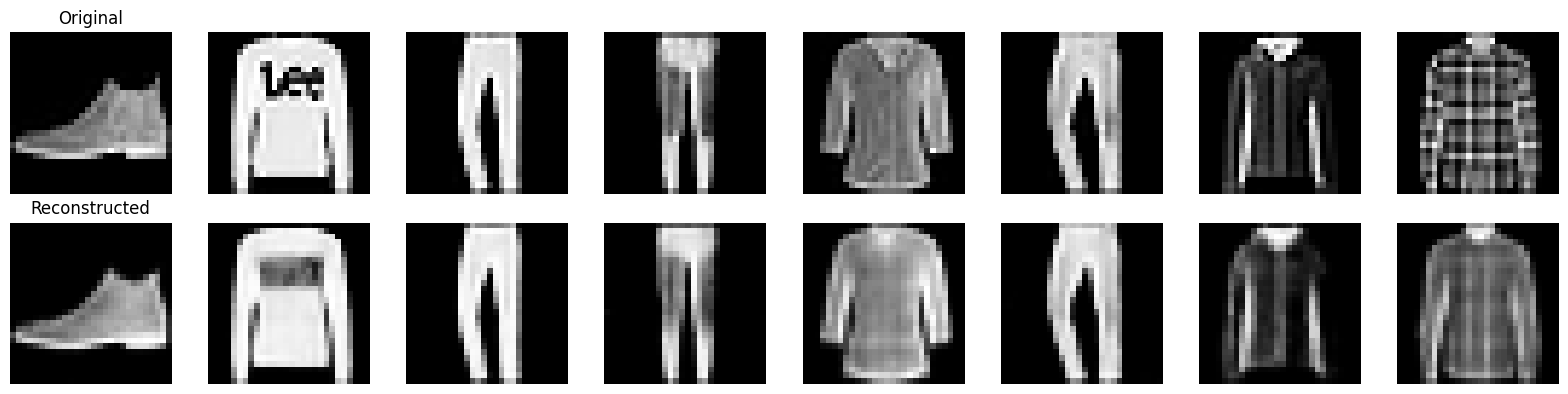

In [93]:
# возьмем батч из test_dataloader
batch = next(iter(data.test_dataloader()))
x, _ = batch
x = x.to(autoenc.device)

# реконструкция
with torch.no_grad():
    x_hat = autoenc(x)

# возьмем первые 8 картинок для примера
n = 8
x = x[:n]
x_hat = x_hat[:n]

# рисуем два ряда: сверху оригиналы, снизу реконструкции
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))

for i in range(n):
    axes[0, i].imshow(x[i, 0].cpu(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(x_hat[i, 0].cpu(), cmap="gray")
    axes[1, i].axis("off")

axes[0, 0].set_title("Original")
axes[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.show()